<a href="https://colab.research.google.com/github/Pierre-Aurelien/REBECA/blob/main/REBECA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import os,datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np  
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format = 'retina'
from google.colab import files
import io

# Pre-process data

In [ ]:
uploaded = files.upload()

df = pd.read_csv(io.BytesIO(uploaded['Evfratov_dataset.csv']))

Saving Evfratov_dataset.csv to Evfratov_dataset.csv


In [ ]:
df['UTR']=df.apply(lambda row: row['Sequence'][:-3],axis=1) #Remove Methionine codon
df['UTR_length']=df.apply(lambda row: len(row['UTR']),axis=1)
df.head()

,Sequence,F1,F2,F3,F4,F5,F6,F7,F8,Bin mode,Precision,UTR,UTR_length
0,AAAAAAACGUGUCUGAACAACCAGUGCGAAAUG,0.0,0.0,0.0,0.000063,0.000000,0.000000,0.0,0.0,3,23,AAAAAAACGUGUCUGAACAACCAGUGCGAA,30
1,AAAAAAGAAUGUAAUCGAGAGAUAAGGGAUAUG,0.0,0.0,0.0,0.000000,0.000056,0.000000,0.0,0.0,4,25,AAAAAAGAAUGUAAUCGAGAGAUAAGGGAU,30
2,AAAAAAUACAUUAUGGUUACCUCGAACGAGAUG,0.0,0.0,0.0,0.000069,0.000000,0.000000,0.0,0.0,3,25,AAAAAAUACAUUAUGGUUACCUCGAACGAG,30
3,AAAAACAAGCGGAUGUCAUAGGAACCGUAGAUG,0.0,0.0,0.0,0.000000,0.000067,0.000000,0.0,0.0,4,30,AAAAACAAGCGGAUGUCAUAGGAACCGUAG,30
4,AAAAAGGUUUGUUAUGGUGGACCGGGAAUGAUG,0.0,0.0,0.0,0.000000,0.000000,0.000021,0.0,0.0,5,21,AAAAAGGUUUGUUAUGGUGGACCGGGAAUG,30


## Quality Check- Only keep the sequences with enough reads (Precision>15)

In [ ]:
df=df[df['Precision']>=1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28402 entries, 0 to 28401
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sequence    28402 non-null  object 
 1   F1          28402 non-null  float64
 2   F2          28402 non-null  float64
 3   F3          28402 non-null  float64
 4   F4          28402 non-null  float64
 5   F5          28402 non-null  float64
 6   F6          28402 non-null  float64
 7   F7          28402 non-null  float64
 8   F8          28402 non-null  float64
 9   Bin mode    28402 non-null  int64  
 10  Precision   28402 non-null  int64  
 11  UTR         28402 non-null  object 
 12  UTR_length  28402 non-null  int64  
dtypes: float64(8), int64(3), object(2)
memory usage: 3.0+ MB


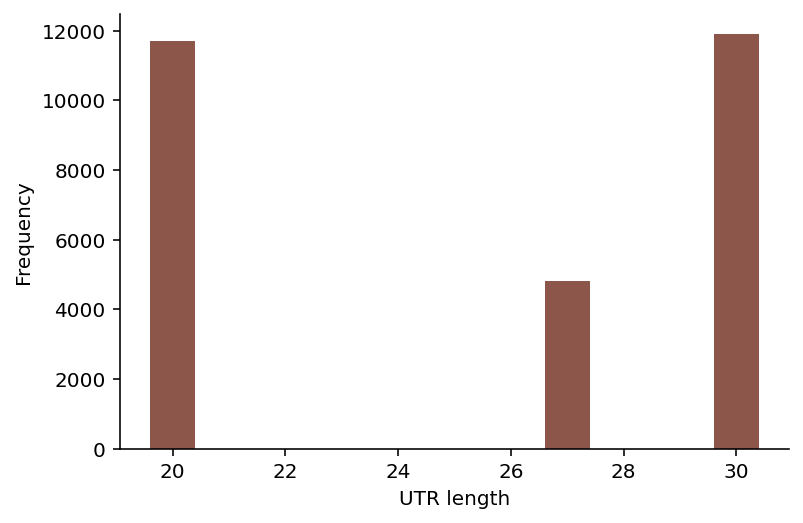

In [ ]:
UL=np.unique(df['UTR_length'], return_index=True, return_inverse=True, return_counts=True)
plt.bar(x=UL[0],height=UL[3],color='tab:brown')
plt.xlabel('UTR length'),plt.ylabel('Frequency')
sns.despine()

## Split dataset intro Training, Validation and Test sets



###Checking data imbalance

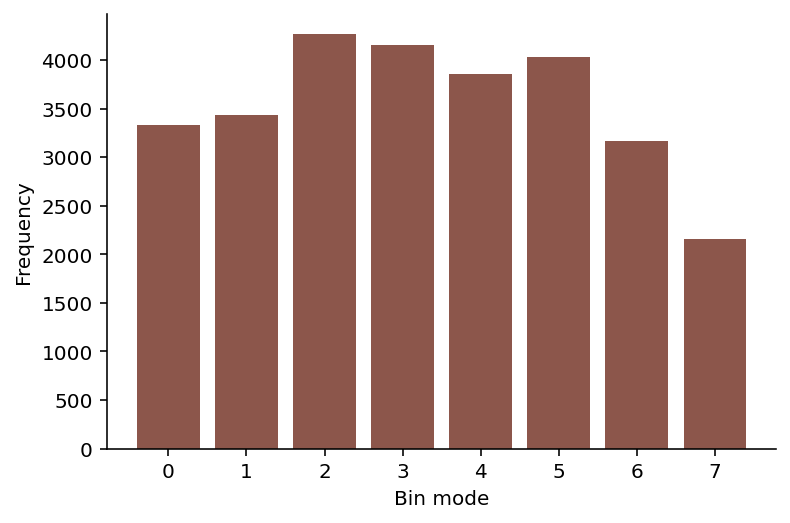

In [32]:
DI=np.unique(df['Bin mode'], return_index=True, return_inverse=True, return_counts=True)
plt.bar(x=DI[0],height=DI[3],color='tab:brown')
plt.xlabel('Bin mode'),plt.ylabel('Frequency')
sns.despine()

In [ ]:
ID_tt=train_test_split(df['UTR'], df['Bin mode'],stratify=df['Bin mode'], test_size=0.053, random_state=11)
df_train_index,df_test_index = ID_tt[0].index, ID_tt[1].index   #Test set size: 1500 sequences
test_set,df_train=df.drop(df_train_index),df.drop(df_test_index)
ID_tv=train_test_split(df_train['UTR'], df_train['Bin mode'],stratify=df_train['Bin mode'], test_size=0.056, random_state=11)
df_train_index,df_val_index = ID_tv[0].index,ID_tv[1].index   #Validation set size: 1500 sequences
train_set,validation_set=df_train.drop(df_val_index),df_train.drop(df_train_index)

## Clean sequences+Padding+Data Augmentation

In [ ]:
# Create One-hot encode function
def one_hot_encode(seq):
    mapping = dict(zip('ACGU', range(4)))    
    seq2 = [mapping[i] for i in seq]
    return np.eye(4)[seq2]

In [ ]:
padd=30
data_augmentation=(train_set[train_set['UTR_length']==20]).count()[0]
Nb_examples=len(train_set)+10*data_augmentation
X_train = np.empty((Nb_examples, padd, 4))
y_train=np.empty((Nb_examples))
p=-1

for i in range(len(train_set)):
    p+=1
    Seq=train_set["UTR"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_train[p]=np.pad(OHE, ((0,padding_number), (0, 0)), 'constant')
    y_train[p]=train_set["Bin mode"].iloc[i]
    if train_set["UTR_length"].iloc[i]==20:
        while padding_number>0 :
          p+=1
          padding_number-=1
          X_train[p]=np.pad(OHE, ((10-padding_number, padding_number), (0, 0)), 'constant')
          y_train[p]=train_set["Bin mode"].iloc[i]
  
Nb_examples=len(validation_set)
X_val = np.empty((Nb_examples, padd, 4))
y_val=np.empty((Nb_examples))

for i in range(len(validation_set)):
    Seq=validation_set["UTR"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_val[i]=np.pad(OHE, ((0,padding_number), (0, 0)), 'constant')
    y_val[i]=validation_set["Bin mode"].iloc[i]

Nb_examples=len(test_set)
X_test = np.empty((Nb_examples, padd, 4))
y_test=np.empty((Nb_examples))

for i in range(len(test_set)):
    Seq=test_set["UTR"].iloc[i]
    OHE=one_hot_encode(Seq)
    padding_number=padd-len(Seq)
    X_test[i]=np.pad(OHE, ((0,padding_number), (0, 0)), 'constant')
    y_test[i]=test_set["Bin mode"].iloc[i]


In [33]:
len(y_train),len(y_val),len(y_test)

(130299, 1507, 1506)

## Visual Representation of one-hot encoding

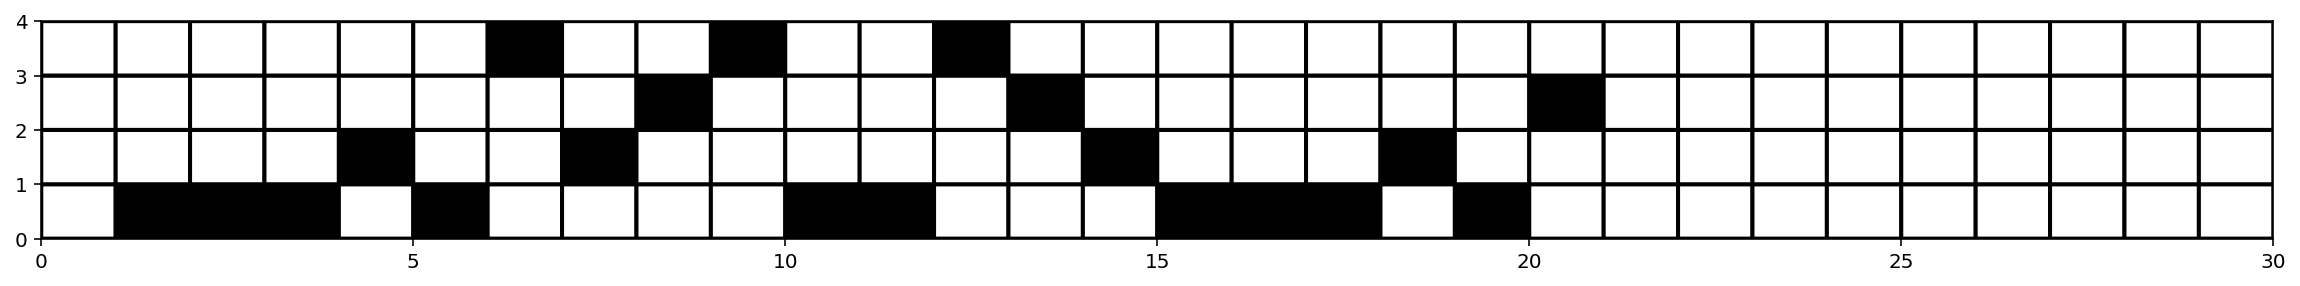

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,2))    
ax1.pcolor(np.transpose(X_train[12068]),cmap="gray_r", edgecolors='k', linewidths=2)

# Assessing the baseline by simply looking at data imbalance



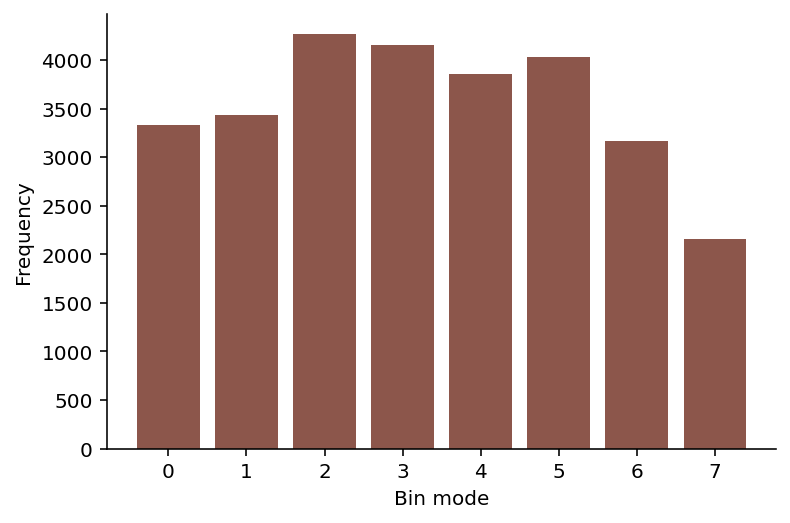

In [ ]:
DI=np.unique(df['Bin mode'], return_index=True, return_inverse=True, return_counts=True)
plt.bar(x=DI[0],height=DI[3],color='tab:brown')
plt.xlabel('Bin mode'),plt.ylabel('Frequency')
sns.despine()

Let's consider the algorithm returning bin No.2 all the time:

In [34]:
from sklearn import metrics
# True values
y_true = test_set['Bin mode'].values
# Predicted values
y_pred =[2 for i in y_true]
metrics.confusion_matrix(y_true, y_pred)
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[  0   0 177   0   0   0   0   0]
 [  0   0 182   0   0   0   0   0]
 [  0   0 226   0   0   0   0   0]
 [  0   0 220   0   0   0   0   0]
 [  0   0 204   0   0   0   0   0]
 [  0   0 214   0   0   0   0   0]
 [  0   0 168   0   0   0   0   0]
 [  0   0 115   0   0   0   0   0]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000       177
           1      0.000     0.000     0.000       182
           2      0.150     1.000     0.261       226
           3      0.000     0.000     0.000       220
           4      0.000     0.000     0.000       204
           5      0.000     0.000     0.000       214
           6      0.000     0.000     0.000       168
           7      0.000     0.000     0.000       115

    accuracy                          0.150      1506
   macro avg      0.019     0.125     0.033      1506
weighted avg      0.023     0.150     0.039      1506



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Deploying Neural Network

In [35]:
# Dealing with an imbalanced dataset
CW=1/(10*np.unique(y_train, return_index=True, return_inverse=True, return_counts=True)[3]/len(y_train))
Class_weights=dict(zip(np.arange(9),CW))

In [36]:
Rebeca=keras.models.Sequential([
             keras.layers.Conv1D(128,4,input_shape=[30,4]),
             keras.layers.Conv1D(64,8),
             keras.layers.MaxPool1D(2),
             keras.layers.Bidirectional(keras.layers.LSTM(50,dropout=0.3)),
             keras.layers.Dense(8, activation='softmax')
])

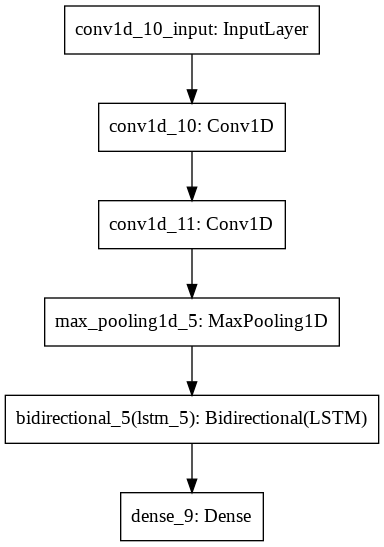

In [ ]:
keras.utils.plot_model(Rebeca)

In [51]:
initial_learning_rate = 0.015
decay_steps = 1.0
decay_rate = 0.5
learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, decay_steps, decay_rate)

adm = keras.optimizers.Adam(learning_rate=0.001,clipvalue=1.0)

In [55]:
Rebeca.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(
                  learning_rate=learning_rate_fn),
                  metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history=Rebeca.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=3,verbose=1,batch_size=32,callbacks=callback)

Epoch 1/3
4072/4072 [==============================] - 41s 10ms/step - loss: 0.8122 - accuracy: 0.6956 - val_loss: 1.1748 - val_accuracy: 0.5322
Epoch 2/3
4072/4072 [==============================] - 42s 10ms/step - loss: 0.8102 - accuracy: 0.6972 - val_loss: 1.1742 - val_accuracy: 0.5315
Epoch 3/3
4072/4072 [==============================] - 42s 10ms/step - loss: 0.8072 - accuracy: 0.6970 - val_loss: 1.1741 - val_accuracy: 0.5309


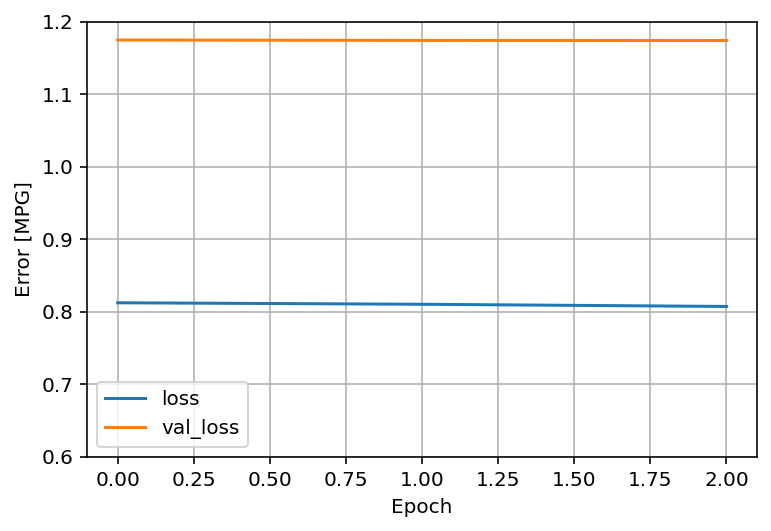

In [59]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0.6, 1.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
Rebeca.save('Rebeca_v1.2.h5')
files.download('Rebeca_v1.2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Assessing Rebeca's performance

In [ ]:
uploaded = files.upload()

Saving Rebeca_v1.2.h5 to Rebeca_v1.2 (1).h5


In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = keras.models.load_model('Rebeca_v1.2.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 27, 128)           2176      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 20, 64)            65600     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               46000     
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 808       
Total params: 114,584
Trainable params: 114,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn import metrics
# True values
y_true = test_set['Bin mode'].values
# Predicted values
y_pred =[i.argmax() for i in new_model.predict(X_test)]

metrics.confusion_matrix(y_true, y_pred)
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[121  27   8   6   6   0   4   5]
 [ 32 101  23  10   4   3   4   5]
 [ 20  21 123  35  13   8   4   2]
 [ 10  14  28 113  33  15   5   2]
 [  1   8  12  21 108  31  17   6]
 [  5   3   1   5  31 110  46  13]
 [ 10   1   2   2   8  31  66  48]
 [  2   0   2   1   3  10  16  81]]
              precision    recall  f1-score   support

           0      0.602     0.684     0.640       177
           1      0.577     0.555     0.566       182
           2      0.618     0.544     0.579       226
           3      0.585     0.514     0.547       220
           4      0.524     0.529     0.527       204
           5      0.529     0.514     0.521       214
           6      0.407     0.393     0.400       168
           7      0.500     0.704     0.585       115

    accuracy                          0.546      1506
   macro avg      0.543     0.555     0.546      1506
weighted avg      0.549     0.546     0.545      1506



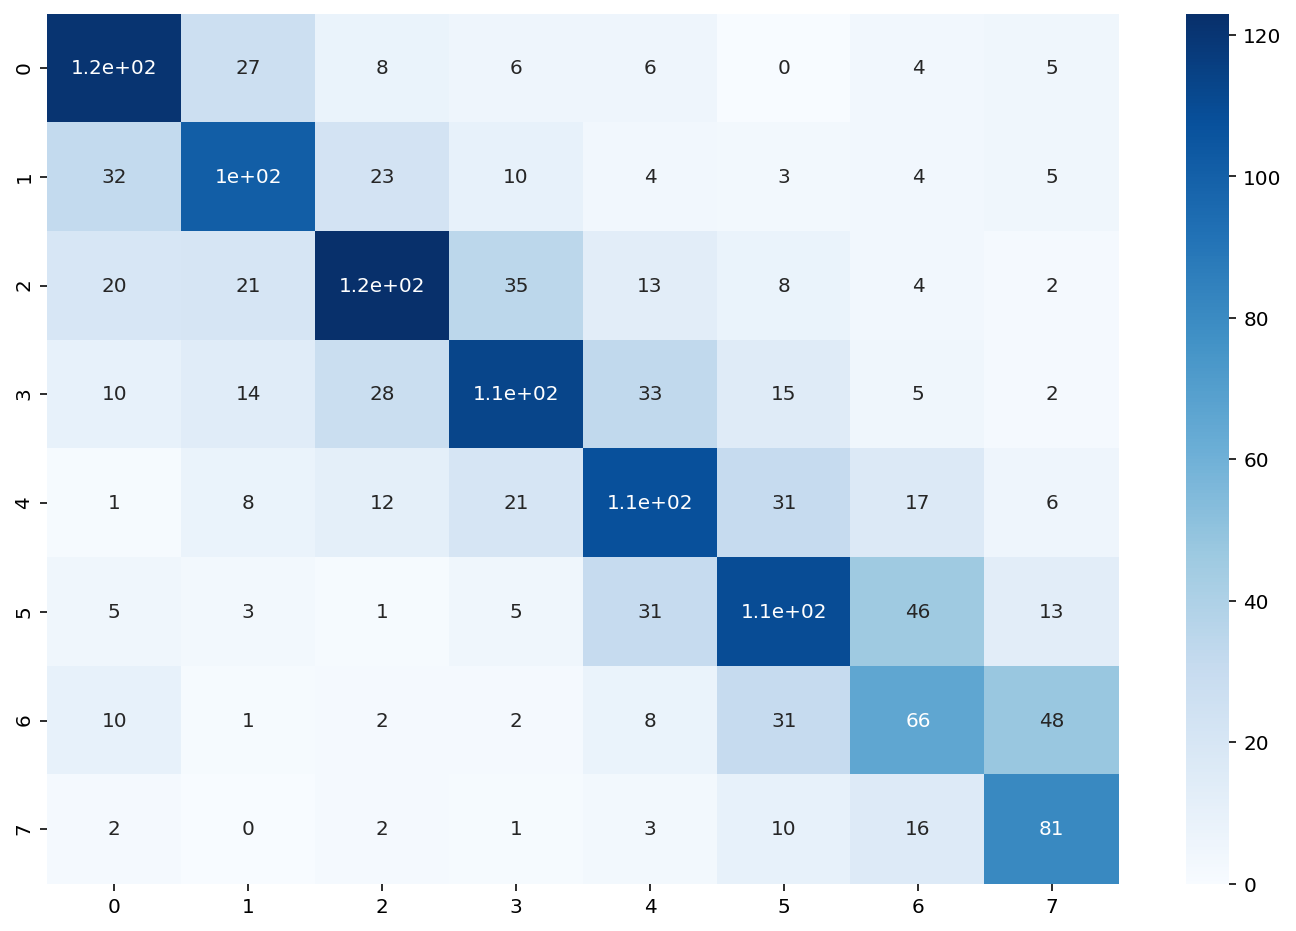

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
cm=metrics.confusion_matrix(y_true, y_pred)
#cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm=cm.astype('float') /len(y_test)
#cm[cm < 0.03] = 0
ax = sns.heatmap(cm, cmap="Blues",annot=True)